In [1]:
import pandas as pd
import sqlite3

In [2]:
connection = sqlite3.connect('data/checking-logs.sqlite')

In [3]:
checker_query = '''
SELECT 
    date(timestamp) AS date,
    time(timestamp) AS time,
    uid
FROM checker
WHERE uid NOT LIKE 'admin_%'
'''
checker_data = pd.read_sql(checker_query, connection)
checker_data

,date,time,uid
0,2020-04-17,05:19:02,user_4
1,2020-04-17,05:22:35,user_4
2,2020-04-17,05:22:45,user_4
3,2020-04-17,05:34:14,user_4
4,2020-04-17,05:34:24,user_4
...,...,...,...
3202,2020-05-21,20:19:06,user_1
3203,2020-05-21,20:22:41,user_1
3204,2020-05-21,20:22:41,user_1
3205,2020-05-21,20:37:00,user_1


In [4]:
def categorize_time_of_day(time_str):
    hour = int(time_str.split(':')[0])
    return hour

In [5]:
checker_data['hour'] = checker_data['time'].apply(categorize_time_of_day)
checker_data['day_of_week'] = pd.to_datetime(checker_data['date']).dt.dayofweek
checker_data

,date,time,uid,hour,day_of_week
0,2020-04-17,05:19:02,user_4,5,4
1,2020-04-17,05:22:35,user_4,5,4
2,2020-04-17,05:22:45,user_4,5,4
3,2020-04-17,05:34:14,user_4,5,4
4,2020-04-17,05:34:24,user_4,5,4
...,...,...,...,...,...
3202,2020-05-21,20:19:06,user_1,20,3
3203,2020-05-21,20:22:41,user_1,20,3
3204,2020-05-21,20:22:41,user_1,20,3
3205,2020-05-21,20:37:00,user_1,20,3


In [6]:
working_days_data = checker_data[checker_data['day_of_week'] < 5]
weekend_data = checker_data[checker_data['day_of_week'] >= 5]

In [7]:
working_days_data

,date,time,uid,hour,day_of_week
0,2020-04-17,05:19:02,user_4,5,4
1,2020-04-17,05:22:35,user_4,5,4
2,2020-04-17,05:22:45,user_4,5,4
3,2020-04-17,05:34:14,user_4,5,4
4,2020-04-17,05:34:24,user_4,5,4
...,...,...,...,...,...
3202,2020-05-21,20:19:06,user_1,20,3
3203,2020-05-21,20:22:41,user_1,20,3
3204,2020-05-21,20:22:41,user_1,20,3
3205,2020-05-21,20:37:00,user_1,20,3


In [8]:
weekend_data

,date,time,uid,hour,day_of_week
23,2020-04-18,07:56:45,user_17,7,5
24,2020-04-18,13:36:53,user_30,13,5
25,2020-04-18,13:42:35,user_2,13,5
26,2020-04-18,13:51:22,user_2,13,5
27,2020-04-18,13:53:17,user_2,13,5
...,...,...,...,...,...
3088,2020-05-17,22:23:05,user_16,22,6
3089,2020-05-17,22:23:11,user_16,22,6
3090,2020-05-17,22:23:11,user_16,22,6
3091,2020-05-17,22:25:15,user_16,22,6


In [9]:
working_days_commits = working_days_data.groupby(['hour']).size()
weekend_commits = weekend_data.groupby(['hour']).size()

In [10]:
working_days_avg = working_days_commits.groupby('hour').mean()
weekend_avg = weekend_commits.groupby('hour').mean()

In [11]:
working_days_avg

hour
0       6.0
3       2.0
5      15.0
6       3.0
7      31.0
8      37.0
9      30.0
10    132.0
11     88.0
12     79.0
13     73.0
14    122.0
15    141.0
16    170.0
17    192.0
18    167.0
19    214.0
20    183.0
21    292.0
22     45.0
23     15.0
dtype: float64

In [12]:
weekend_avg

hour
0       6.0
1       6.0
3       1.0
5       2.0
7      16.0
8      28.0
9      22.0
10     28.0
11    118.0
12     57.0
13    108.0
14     87.0
15    114.0
16     74.0
17     50.0
18     68.0
19    105.0
20    117.0
21     72.0
22     59.0
23     32.0
dtype: float64

In [13]:
avg_commits = pd.DataFrame({
    'hour': working_days_avg.index,
    'weekend': weekend_avg.values,
    'working_day': working_days_avg.values,
})
avg_commits

,hour,weekend,working_day
0,0,6.0,6.0
1,3,6.0,2.0
2,5,1.0,15.0
3,6,2.0,3.0
4,7,16.0,31.0
5,8,28.0,37.0
6,9,22.0,30.0
7,10,28.0,132.0
8,11,118.0,88.0
9,12,57.0,79.0


Text(0.5, 0, 'hour')

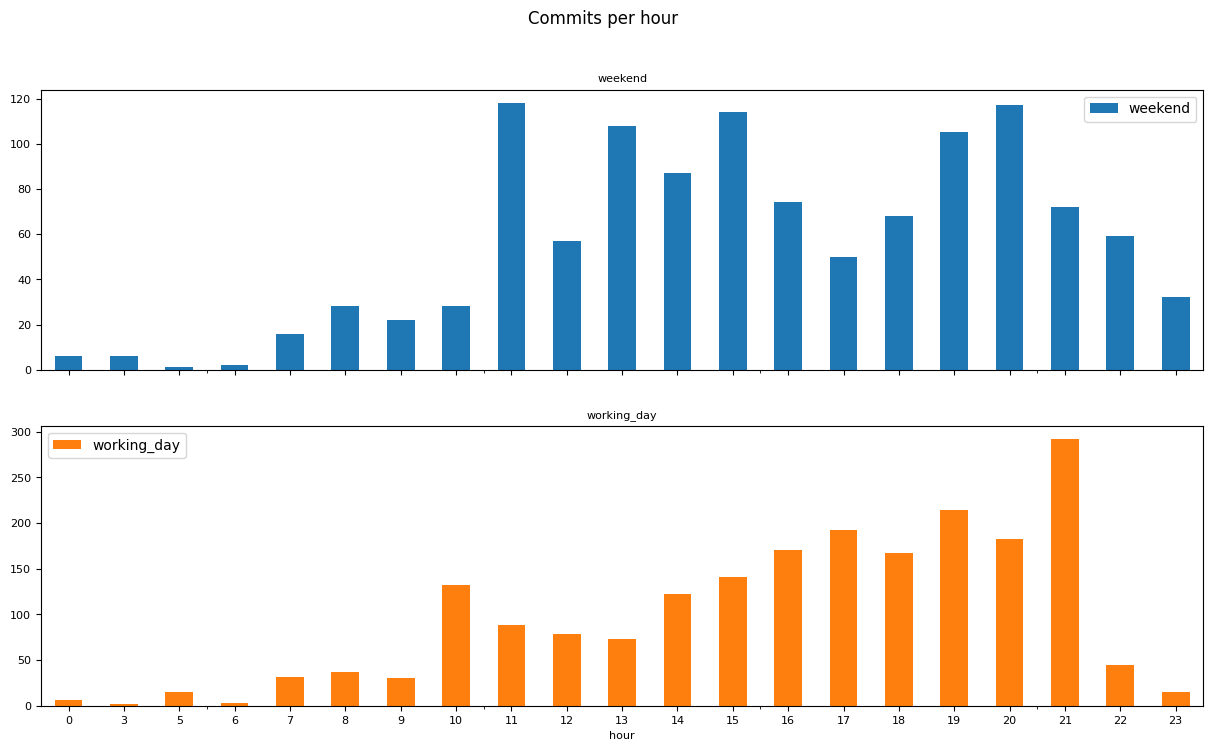

In [14]:
graph = avg_commits.plot(
    kind='bar',
    x='hour',
    subplots=True,
    layout=(2, 1),
    figsize=(15, 8),
    fontsize=8,
    legend=True,
    sharex=True,
    title='Commits per hour',
    rot=0
)
graph[0, 0].set_title('weekend', fontsize=8)
graph[1, 0].set_title('working_day', fontsize=8)
graph[1, 0].set_xlabel('hour', fontsize=8)

In [15]:
connection.close()

Отличается ли динамика в рабочие и выходные дни?

In [16]:
max_working_day_hour = working_days_avg.idxmax()
max_weekend_hour = weekend_avg.idxmax()
print(f'В {max_working_day_hour} количество фиксаций наибольшее в рабочие дни')
print(f'В {max_weekend_hour} количество фиксаций наибольшее в выходные дни')

В 21 количество фиксаций наибольшее в рабочие дни
В 11 количество фиксаций наибольшее в выходные дни
